##1. 사전 훈련된 Glove 다운

In [1]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [3]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall()
zf.close()

In [4]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
  word_vector = line.split()
  word = word_vector[0]
  word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
  glove_dict[word] = word_vector_arr

f.close()

##2. 사전 훈련된 FastText 다운

In [5]:
!pip install fasttext

     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094805 sha256=f176c04edd3e51b5e04419b2da93ffcf66a6aec4b3276efa425c2deb2d3c5438
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [6]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [8]:
pip install gensim

##3. 사전 훈련된 Word2Vec 다운

In [7]:
urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.model.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

AttributeError: ignored

##3. 문장 임베딩

In [11]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [12]:
def calculate_sentence_vector(sentence):
  return sum([glove_dict.get(word, zero_vector)
  for word in sentence])/len(sentence)

In [13]:
kor_sent = ['전', '좋은', '힉생', '입니다']
sentence_vector = calculate_sentence_vector(kor_sent)
print(sentence_vector)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


##4. 텍스트 랭크를 이용한 텍스트 요약

In [24]:
import numpy as np
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [33]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
stop_words = stopwords.words('english')

In [18]:
urlretrieve("https://raw.githubusercontent.com/prateekjoshi565/textrank_text_summarization/master/tennis_articles_v4.csv", 
            filename="tennis_articles_v4.csv")
data = pd.read_csv("tennis_articles_v4.csv")
data.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [34]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)
data

,article_text,sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...


In [38]:
def tokenization(sentences):
  return [word_tokenize(sentence) for sentence in sentences]

def preprocess_sentence(sentence):
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
  return [word for word in sentence if word not in stop_words and word]

def preprocess_sentences(sentences):
  return [preprocess_sentence(sentence) for sentence in sentences]

In [39]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data

,article_text,sentences,tokenized_sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...,"[[maria, sharapova, basically, friends, tennis..."
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc...","[[basel, switzerland, ap, roger, federer, adva..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...,"[[roger, federer, revealed, organisers, relaun..."
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...,"[[kei, nishikori, try, end, long, losing, stre..."
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over...","[[federer, first, broke, tour, two, decades, a..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...,"[[nadal, played, tennis, since, forced, retire..."
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e...","[[tennis, giveth, tennis, taketh, away], [end,..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...,"[[federer, swiss, indoors, last, week, beating..."


In [40]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [41]:
def calculate_sentence_vector(sentence):
  if len(sentence) != 0:
    return sum([glove_dict.get(word, zero_vector)
    for word in sentence])/len(sentence)

  else:
    return zero_vector

In [42]:
def sentences_to_vectors(sentences):
  return [calculate_sentence_vector(sentence)
  for sentence in sentences]

In [43]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)
data[['SentenceEmbedding']]

,SentenceEmbedding
0,"[[0.051488996, 0.1105585, 0.6950863, 0.1891917..."
1,"[[0.10566062456928194, -0.10534465219825506, 0..."
2,"[[-0.022272188, -0.0474477, 0.14933074, -0.086..."
3,"[[0.045201838, -0.064647146, 0.5035717, -0.160..."
4,"[[0.21536233, 0.180915, 0.25600883, 0.06924241..."
5,"[[0.04484453, -0.0074302587, 0.33349112, -0.07..."
6,"[[-0.115338005, -0.0062844106, 0.595185, -0.16..."
7,"[[0.0740439, 0.059211146, 0.49143884, 0.216771..."


In [47]:
def similarity_matrix(sentence_embedding):
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                        sentence_embedding[j].reshape(1, embedding_dim))[0, 0]
  return sim_mat

In [48]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']

0    [[1.0, 0.6477208733558655, 0.5915699601173401,...
1    [[1.0, 0.8745531210608367, 0.8054854557907093,...
2    [[1.0000001192092896, 0.9130854606628418, 0.89...
3    [[0.9999998807907104, 0.7769179305294042, 0.84...
4    [[1.0000001192092896, 0.8306209732530097, 0.90...
5    [[1.0, 0.8843014240264893, 0.8540289072721128,...
6    [[1.0, 0.473054975271225, 0.45002683997154236,...
7    [[1.0, 0.7634095600081804, 0.7822569012641907,...
Name: SimMatrix, dtype: object

In [49]:
print('두번째 샘플의 문장 개수 :',len(data['tokenized_sentences'][1]))
print('두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :',np.shape(data['SentenceEmbedding'][1]))
print('두번째 샘플의 유사도 행렬의 크기(shape) :',data['SimMatrix'][1].shape)

두번째 샘플의 문장 개수 : 12
두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (12, 100)
두번째 샘플의 유사도 행렬의 크기(shape) : (12, 12)


In [50]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

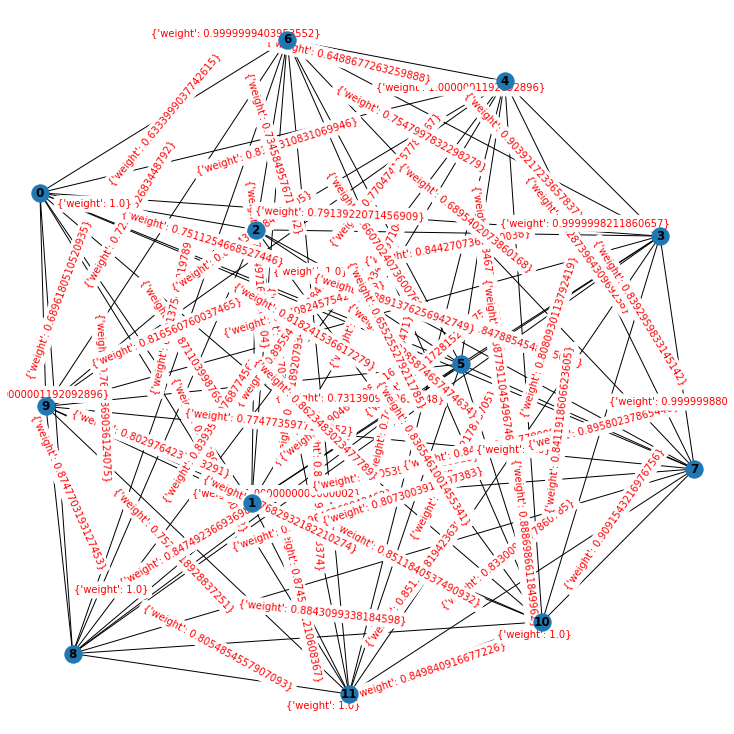

In [51]:
draw_graphs(data['SimMatrix'][1])

In [52]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [53]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0, 0.6477208733558655, 0.5915699601173401,...","{0: 0.05492159242624364, 1: 0.0628651999814638..."
1,"[[1.0, 0.8745531210608367, 0.8054854557907093,...","{0: 0.08315094474060455, 1: 0.0849861140529650..."
2,"[[1.0000001192092896, 0.9130854606628418, 0.89...","{0: 0.06148440881336138, 1: 0.0622486433297316..."
3,"[[0.9999998807907104, 0.7769179305294042, 0.84...","{0: 0.08164727931345296, 1: 0.0727647944644765..."
4,"[[1.0000001192092896, 0.8306209732530097, 0.90...","{0: 0.055686900055508824, 1: 0.050992318615516..."
5,"[[1.0, 0.8843014240264893, 0.8540289072721128,...","{0: 0.08288694357042936, 1: 0.0840376024640333..."
6,"[[1.0, 0.473054975271225, 0.45002683997154236,...","{0: 0.07336251752688192, 1: 0.1050889008112474..."
7,"[[1.0, 0.7634095600081804, 0.7822569012641907,...","{0: 0.043210392890095706, 1: 0.047333398905178..."


In [54]:
def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) 
                         for i,s in enumerate(sentences)), 
                                reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [55]:
data['summary'] = data.apply(lambda x: 
                            ranked_sentences(x.sentences, 
                            x.score), axis=1)

In [56]:
for i in range(0, len(data)):
  print(i+1,'번 문서')
  print('원문 :',data.loc[i].article_text)
  print('')
  print('요약 :',data.loc[i].summary)
  print('')

1 번 문서
원문 : Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're i